# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista.

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [15]:
df.set_index('Data Emissão', inplace=True)
df_2020 = df['2020-01-01':]

df_2020.dropna(inplace=True)
df_2020.reset_index(inplace=True)
df_2020.head()

,Data Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado
2,2020-01-01,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,35.90,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Alimentos
3,2020-01-01,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,21.77,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Farmácia
4,2020-01-01,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,80.95,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Restaurantes


In [16]:
print(df_2020['Data Emissão'].min())
print(df_2020['Data Emissão'].max())

2020-01-01 00:00:00
2021-12-31 00:00:00


<Axes: xlabel='categoria', ylabel='Retorno'>

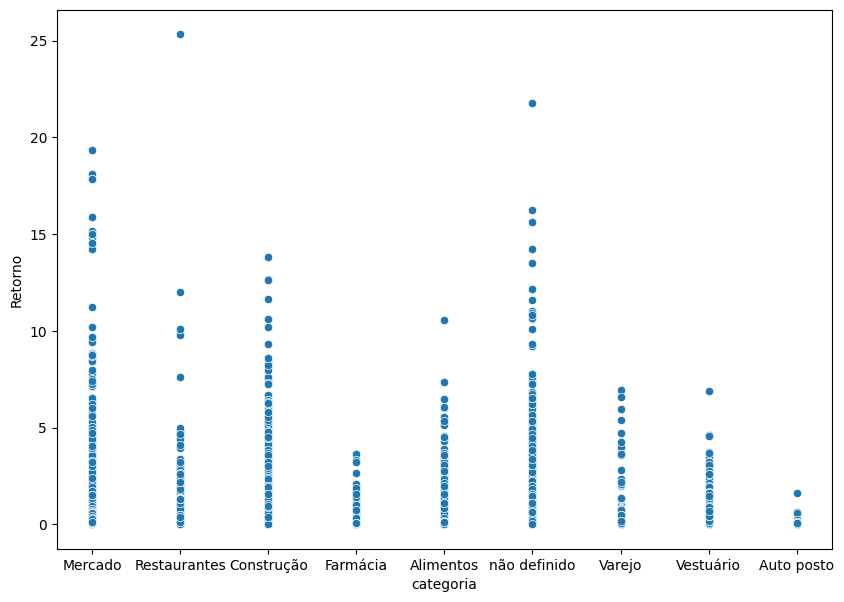

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(ax=ax, data=df_2020[(df_2020['Retorno'] > 0) & (df_2020['Retorno'] < 200)], x='categoria', y='Retorno')

<Axes: xlabel='categoria', ylabel='count'>

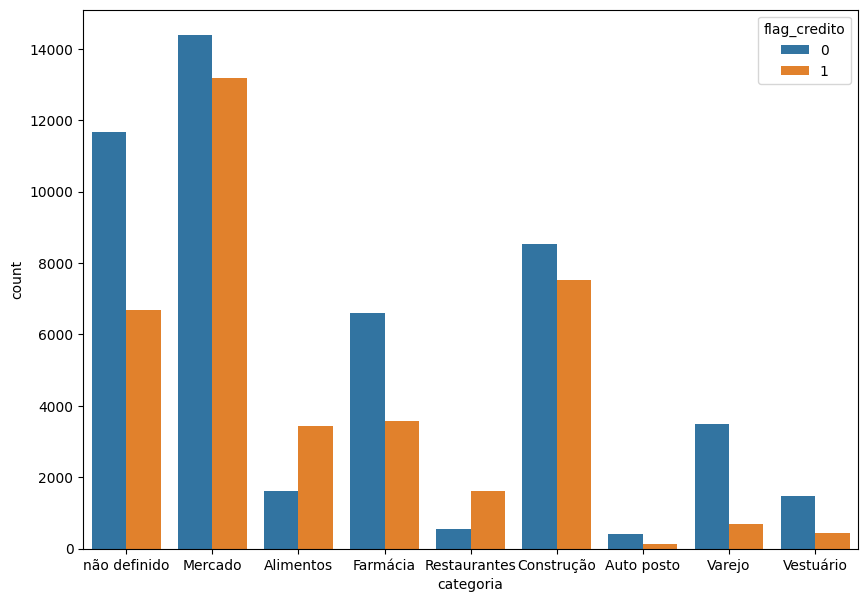

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot(ax=ax, data=df_2020, x='categoria', hue='flag_credito')

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [19]:
tab = pd.crosstab(df_2020.categoria, df_2020.flag_credito, margins=True, margins_name='total')

tab['odds'] = tab[1]/tab[0]
tab['odds_ratio'] = tab['odds']/tab.loc['total', 'odds']
tab['woe'] = np.log(tab.odds_ratio)
tab

flag_credito,0,1,total,odds,odds_ratio,woe
categoria,,,,,,
Alimentos,1608,3442,5050,2.140547,2.792382,1.026895
Auto posto,405,135,540,0.333333,0.434839,-0.832779
Construção,8521,7523,16044,0.882878,1.151730,0.141265
Farmácia,6607,3582,10189,0.542152,0.707247,-0.346375
Mercado,14376,13177,27553,0.916597,1.195717,0.178746
Restaurantes,553,1626,2179,2.940325,3.835707,1.344354
Varejo,3481,701,4182,0.201379,0.262702,-1.336733
Vestuário,1472,443,1915,0.300951,0.392596,-0.934974
não definido,11659,6689,18348,0.573720,0.748428,-0.289780


<Axes: xlabel='categoria', ylabel='woe'>

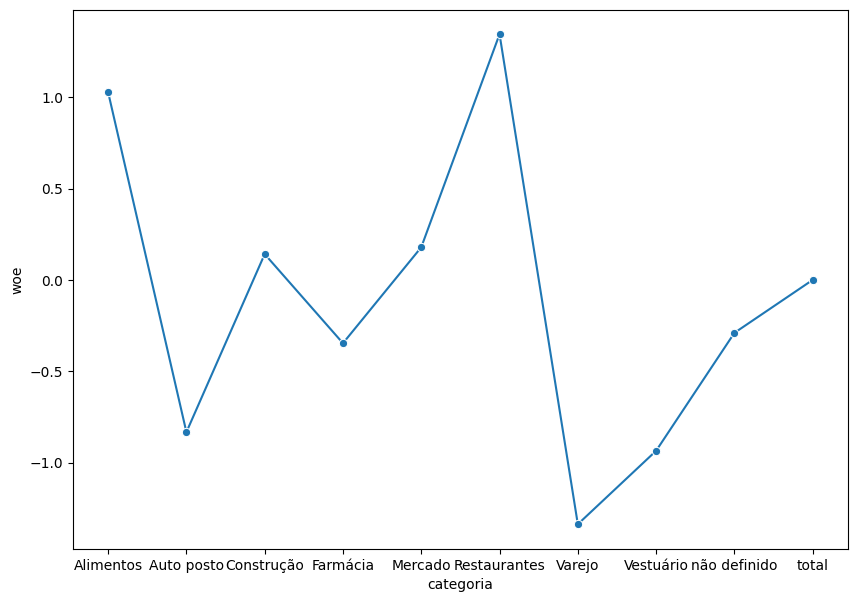

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(ax=ax, data=tab, x='categoria', y='woe', marker='o')

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [21]:
tab = pd.crosstab(df_2020.categoria, df_2020.flag_credito,margins=True, margins_name='total')

rotulo_evento = tab.columns[0]
rotulo_nao_evento = tab.columns[1]

tab['pct_evento'] = tab[rotulo_evento]/tab.loc['total', rotulo_evento]
tab['pct_nao_evento'] = tab[rotulo_nao_evento]/tab.loc['total', rotulo_nao_evento]
tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe

print(tab.iv_parcial.sum())

tab

0.24096448519764424


flag_credito,0,1,total,pct_evento,pct_nao_evento,woe,iv_parcial
categoria,,,,,,,
Alimentos,1608,3442,5050,0.033031,0.092234,-1.026895,0.060796
Auto posto,405,135,540,0.008319,0.003618,0.832779,0.003916
Construção,8521,7523,16044,0.175034,0.201592,-0.141265,0.003752
Farmácia,6607,3582,10189,0.135718,0.095986,0.346375,0.013762
Mercado,14376,13177,27553,0.295304,0.353100,-0.178746,0.010331
Restaurantes,553,1626,2179,0.011359,0.043571,-1.344354,0.043304
Varejo,3481,701,4182,0.071505,0.018785,1.336733,0.070473
Vestuário,1472,443,1915,0.030237,0.011871,0.934974,0.017172
não definido,11659,6689,18348,0.239493,0.179243,0.289780,0.017459


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


WOE - análise das categorias:

Chance de evento: alimentos e restaurantes

Chance de não eventos: Auto posto, Varejo e Vestuário

**IV Information Value:**

Na tabela de Naeem Siddiqi, a variável tem poder preditivo fraco.

Naeem Siddiqi recomenda as seguintes regras de bolso para interpretar o IV:



|Faixa|Poder preditivo
|:-|:-|
|0 a 0,02|Inútil
|0,02 a 0,1|Fraco
|0,1 a 0,3|Médio
|0,3 a 0,5|Forte
|0,5 ou mais|Suspeito de tão alto

Lembro que Siddiqi recomenda estas regras de bolso da experiência dele, que é muito vasta em modelos de crédito. Outras áreas de concentração podem tender a apresentar relações mais sutís ou mais evidentes.

